# Inference notebook for the ResNet-50 model trained on ImageNet

This notebook demonstrates inference with a ResNet-50 model trained on the ImageNet dataset. In this notebook you will be able to run inference on some sample images and measure the latency of the model

## First let's set some variables

Fill in below the values for the path to your code and modle checkpoint, which GPU you will be using (specify -1 to use the CPU). You can refer to the training recipe to access a checkpoint if you haven't trained the model yourself.

In [1]:
# specify the gpu to use
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# path to tensorflow/models repository
import sys
sys.path.append("/ebs/code/models/")

import tensorflow as tf
import numpy as np

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
CHECKPOINT_PATH = "./output-v4/"
# select checkpoint# selec 
checkpoint_file = os.path.join(CHECKPOINT_PATH, 'checkpoint')
with open(checkpoint_file,'r') as chkf:
    last_chkpnt = chkf.readline().split(' ')[1][1:-2]
    last_chkpnt = os.path.join(CHECKPOINT_PATH, last_chkpnt)
    print("loading checkpoint", last_chkpnt)

loading checkpoint ./output-v4/model.ckpt-500000


## Load the model

In [3]:
from official.resnet import resnet_model
from preprocess import preprocess_for_eval, _DEFAULT_IMAGE_SIZE, _RESIZE_SIDE_MIN

image_data = tf.placeholder(tf.string)

features = preprocess_for_eval(image_data, _DEFAULT_IMAGE_SIZE, _DEFAULT_IMAGE_SIZE, _RESIZE_SIDE_MIN)
features = tf.expand_dims(features, 0)

model = resnet_model.Model(
    resnet_size=50,
    bottleneck=True,
    num_classes=1000,
    num_filters=64,
    kernel_size=7,
    conv_stride=2,
    first_pool_size=3,
    first_pool_stride=2,
    block_sizes=[3, 4, 6, 3],
    block_strides=[1, 2, 2, 2],
    final_size=2048,
    resnet_version=2,
    data_format=None,
    dtype=tf.float32)

logits = model(features, False)


In [4]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, last_chkpnt)

INFO:tensorflow:Restoring parameters from ./output-v4/model.ckpt-500000


In [5]:
# load imagenet information

with open("/ebs/code/models/research/inception/inception/data/imagenet_lsvrc_2015_synsets.txt", "r") as fh:
    synsets = [l.strip() for l in fh]
    
with open("/ebs/code/models/research/inception/inception/data/imagenet_metadata.txt", "r") as fh:
    synset2name = dict([l.strip().split("\t") for l in fh])


## Run inference on sample images

Modify the filename below to try out the model on some sample images. We will show the topK predictions of the model.

In [6]:
IMAGE_FILENAME = "./puppy.jpg"

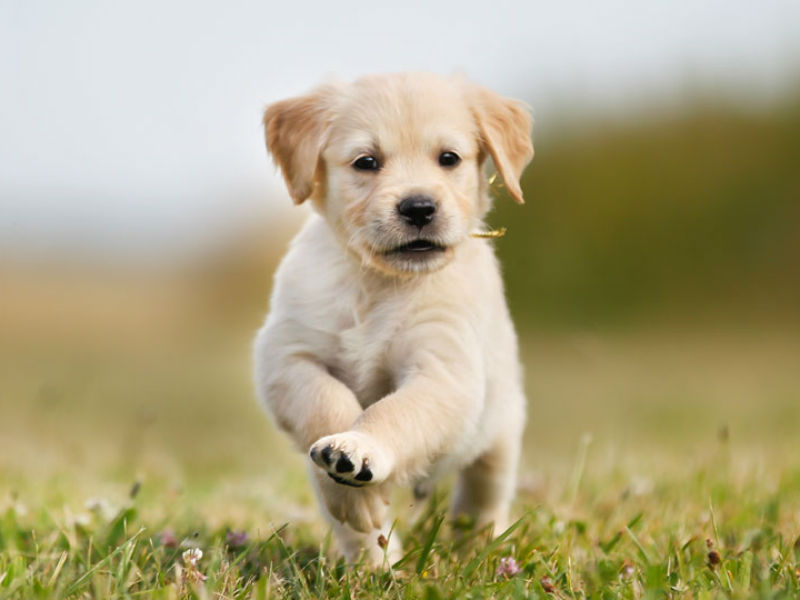

15.06	Labrador retriever
13.18	Chesapeake Bay retriever
9.48	Samoyed, Samoyede
9.25	thatch, thatched roof
8.81	schipperke


In [7]:
from IPython.display import Image, display
display(Image(filename=IMAGE_FILENAME, width=500))

with open(IMAGE_FILENAME, "rb") as fh:
    x = fh.read()
r = sess.run([logits], feed_dict={image_data: x})
l = r[0].flatten()

for i in np.argsort(l)[::-1][:5]:
    print('%.2f\t%s' % (l[i], synset2name[synsets[i+1]]))

## Measure the model latency

We measure how long it takes to run inference on the model with a batch size of 1. This scenario is close to how the model is deployed in production. In order to benchmark performance on the CPU, you can set the CUDA_VISIBLE_DEVICES environment variable to -1.

Measurements on an AWS p3.2xlarge machine
* GPU: avg time = 11ms (+/- 0ms)

In [8]:
from time import time as now

num_steps = 20
num_steps_burn_in = 5

durations = []
for i in range(num_steps + num_steps_burn_in):
    start_time = now()
    _ = sess.run([logits], feed_dict={image_data: x})
    duration = now() - start_time
    if i >= num_steps_burn_in:
        durations.append(duration)
durations = np.array(durations)

print("avg time = %dms (+/- %dms)" % (1000*durations.mean(), 1000*durations.std()))

avg time = 11ms (+/- 0ms)
